<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/04_Transfer_Learning_Feature_Extration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the dataset

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-02-27 05:39:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   178MB/s    in 0.9s    

2024-02-27 05:39:15 (178 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [2]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 director

In [4]:
# Note - we have 10 times less images in training set

## Setting up training and testing data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks
1. Tensorboard
2. ModelCheckpoints
3. EarlyStopping

In [6]:
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorflow log files to: {log_dir}")
  return tensorboard_callback

## Tensorflow Hub


In [7]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-feature-vector/versions/2"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"


In [8]:
def create_model(model_url, num_classes=10):
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url,
                     trainable=False,
                     name="feature_extraction_layer",
                     input_shape=IMAGE_SHAPE+(3,)),
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## Create a model using tensorflow hub url (kaggle)

In [9]:
resnet_model = create_model(resnet_url)
efficientnet_model = create_model(efficientnet_url)

## Visualize both model architectures

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              42626560  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 42647050 (162.69 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________


In [12]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


## Compile and train resnet model

In [17]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving tensorflow log files to: tensorflow_hub/resnet50V2/20240227-054142
Epoch 1/5
24/24 [==============================] - 34s 838ms/step - loss: 1.9904 - accuracy: 0.3667 - val_loss: 1.1974 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 15s 651ms/step - loss: 0.8703 - accuracy: 0.7400 - val_loss: 0.8170 - val_accuracy: 0.7272
Epoch 3/5
24/24 [==============================] - 15s 659ms/step - loss: 0.5920 - accuracy: 0.8253 - val_loss: 0.7357 - val_accuracy: 0.7496
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.4442 - accuracy: 0.8827 - val_loss: 0.6850 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 15s 656ms/step - loss: 0.3616 - accuracy: 0.9120 - val_loss: 0.6537 - val_accuracy: 0.7812


<Axes: >

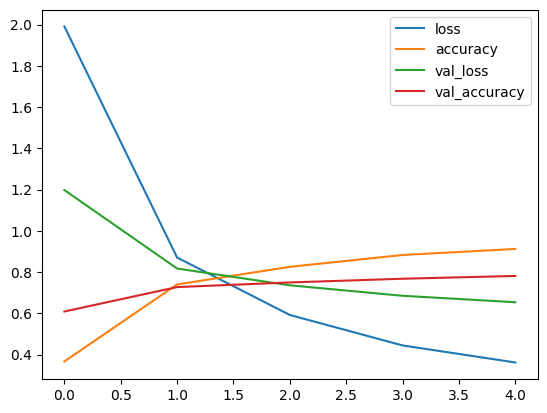

In [20]:
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

## Plot loss curves

In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  train_loss = history.history["loss"]
  train_accuracy = history.history["accuracy"]

  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, train_loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, train_accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel('Epochs')
  plt.legend()

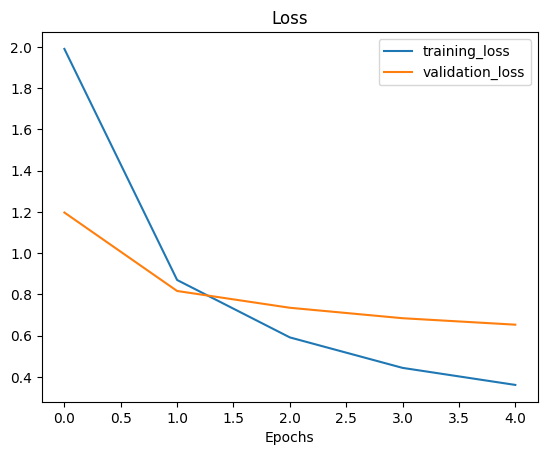

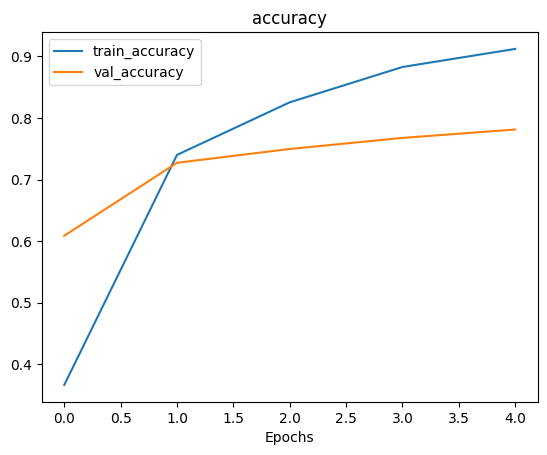

In [18]:
plot_loss_curves(resnet_history)

In [19]:
## Question - How to reduce overfitting on transfer learning model?
## More training dataset?

## Efficient net model

In [15]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnet")])

Saving tensorflow log files to: tensorflow_hub/efficientnet/20240227-054009
Epoch 1/5
24/24 [==============================] - 25s 583ms/step - loss: 1.8313 - accuracy: 0.4413 - val_loss: 1.3113 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 10s 443ms/step - loss: 1.0697 - accuracy: 0.7627 - val_loss: 0.8796 - val_accuracy: 0.8052
Epoch 3/5
24/24 [==============================] - 11s 468ms/step - loss: 0.7653 - accuracy: 0.8427 - val_loss: 0.7142 - val_accuracy: 0.8320
Epoch 4/5
24/24 [==============================] - 12s 493ms/step - loss: 0.6142 - accuracy: 0.8747 - val_loss: 0.6213 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 11s 462ms/step - loss: 0.5196 - accuracy: 0.8880 - val_loss: 0.5667 - val_accuracy: 0.8592


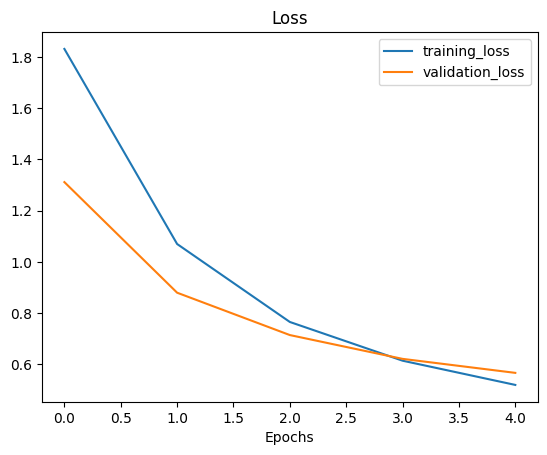

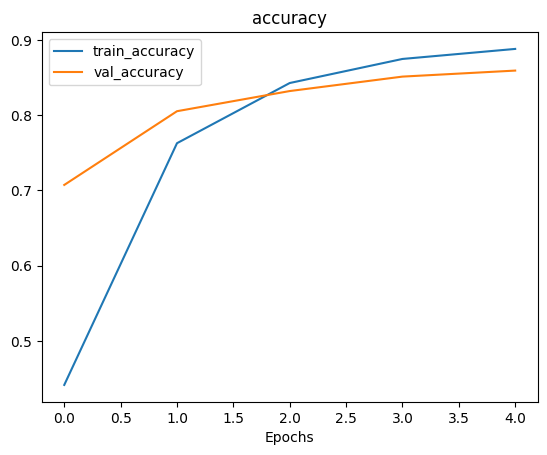

In [16]:
plot_loss_curves(efficientnet_history)